# Dynamic Time Wrapping

# Inisialisasi Konfigurasi untuk Perhitungan DTW pada Rekaman Audio
Kode tersebut melakukan penyiapan awal untuk proses perhitungan Dynamic Time Warping (DTW) antara rekaman lama dan rekaman baru. Pertama, ditetapkan nilai sampling rate (SR = 22050) serta jumlah koefisien MFCC (N_MFCC = 13) yang digunakan dalam ekstraksi fitur audio. Variabel BASE_DIR menunjuk pada direktori utama penyimpanan data, sedangkan OLD_DIRS berisi path dua kategori rekaman lama, yaitu folder buka dan tutup. Variabel NEW_FILES memuat lokasi dua rekaman audio baru, yaitu bukabaru.wav dan tutupbaru.wav, yang akan dibandingkan dengan data lama. Sementara itu, OUT_CSV menentukan nama file keluaran yang menyimpan seluruh hasil komputasi DTW dalam bentuk CSV. Secara keseluruhan, kode ini berfungsi sebagai langkah awal sebelum melakukan ekstraksi MFCC, penghitungan DTW, serta analisis lanjutan.

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

SR = 22050
N_MFCC = 13

# Sesuaikan dengan path hasil ekstraksi ZIP
BASE_DIR = '/mnt/data/user1_unzipped/user1'

OLD_DIRS = {
    'buka': os.path.join(BASE_DIR, 'buka'),
    'tutup': os.path.join(BASE_DIR, 'tutup'),
}

# Jika nantinya kamu ingin menggabungkan file audio buka/tutup jadi 1 file
NEW_FILES = {
    'buka_baru': os.path.join(BASE_DIR, 'bukabaru.wav'),
    'tutup_baru': os.path.join(BASE_DIR, 'tutupbaru.wav'),
}

OUT_CSV = 'dtw_results.csv'


# Fungsi Ekstraksi MFCC dan Perhitungan DTW
Fungsi extract_mfcc dan dtw_distance digunakan untuk memproses serta membandingkan sinyal audio melalui representasi fitur MFCC. Fungsi extract_mfcc menerima path file audio, memuat sinyal dengan sampling rate tertentu, kemudian menghasilkan Mel-Frequency Cepstral Coefficients (MFCC) sebanyak n_mfcc, yang menggambarkan karakteristik spektral suara secara ringkas. Sementara itu, fungsi dtw_distance menghitung jarak antara dua matriks MFCC menggunakan algoritma Dynamic Time Warping (DTW), yang menyesuaikan perbedaan waktu agar kedua sinyal dapat dibandingkan secara sebanding. Fungsi tersebut menghasilkan tiga keluaran: raw (biaya DTW keseluruhan), norm (biaya yang telah dinormalisasi terhadap panjang jalur untuk mengatasi variasi durasi), dan path_len (jumlah langkah pada jalur optimal). Nilai-nilai ini memberikan dasar untuk menganalisis tingkat kemiripan atau perbedaan antara dua rekaman audio.

In [2]:
def extract_mfcc(path, sr=SR, n_mfcc=N_MFCC):
    # Fungsi ini otomatis membaca file .wav dari folder:
    # /mnt/data/user1_unzipped/user1/buka
    # /mnt/data/user1_unzipped/user1/tutup
    y, _ = librosa.load(path, sr=sr, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc


def dtw_distance(m1, m2, metric='euclidean'):
    # Hitung DTW antara 2 MFCC
    D, wp = librosa.sequence.dtw(X=m1, Y=m2, metric=metric)

    raw = D[-1, -1]     # total cost DTW
    path_len = len(wp)  # panjang rute DTW
    norm = raw / path_len if path_len > 0 else np.inf  # normalisasi DTW

    return float(raw), float(norm), int(path_len)


# Pengumpulan dan Persiapan Data Rekaman Lama
Bagian kode ini bertugas menyiapkan seluruh data rekaman lama sebelum proses analisis kesamaan suara dilakukan menggunakan fitur MFCC. Pertama, direktori utama (BASE) beserta folder berisi rekaman lama (OLD_DIRS untuk kategori buka dan tutup) didefinisikan, sementara daftar NEW_FILES disiapkan untuk memuat rekaman baru yang akan dibandingkan. Nilai sampling rate (SR = 16000) dan jumlah koefisien MFCC (N_MFCC = 20) ditetapkan sebagai konfigurasi ekstraksi fitur. Selanjutnya, script mencari seluruh file WAV di setiap folder lama, memverifikasi keberadaan direktori, dan menampilkan jumlah file di masing-masing kategori. MFCC dari setiap rekaman kemudian diekstraksi melalui fungsi extract_mfcc dan disimpan dalam dictionary old_mfcc. Jika rekaman baru tersedia, fitur MFCC-nya juga dapat diolah dan disimpan ke dalam new_mfcc. Secara keseluruhan, kode ini mempersiapkan data audio dalam bentuk representasi numerik sehingga siap digunakan dalam tahap analisis atau perbandingan lebih lanjut, seperti menggunakan algoritma DTW.

In [9]:
import os

def walk_all(root="/mnt/data"):
    for path, dirs, files in os.walk(root):
        print("PATH :", path)
        print(" DIRS:", dirs)
        print(" FILES:", files)
        print("-" * 60)


walk_all("/mnt/data/user1_unzipped/user1")


In [11]:
print(os.listdir("/mnt"))
print(os.listdir("/"))


[]
['opt', 'libx32', 'tmp', 'proc', 'dev', 'bin', 'mnt', 'root', 'srv', 'home', 'var', 'etc', 'sbin', 'usr', 'boot', 'sys', 'lib32', 'lib64', 'media', 'lib', 'run', 'kaggle', '.dockerenv', 'datalab', 'tools', 'content', 'python-apt', 'python-apt.tar.xz', 'NGC-DL-CONTAINER-LICENSE', 'cuda-keyring_1.1-1_all.deb']


In [17]:
from google.colab import files
uploaded = files.upload()


Saving user1.zip to user1.zip


In [18]:
import os
print(os.listdir())

['.config', 'user1.zip', 'sample_data']


In [20]:
import zipfile
import os

# ====================================
# ZIP yang kamu upload (nama otomatis)
# ====================================
zip_files = [f for f in os.listdir() if f.lower().endswith(".zip")]

if len(zip_files) == 0:
    raise FileNotFoundError("Tidak ada file ZIP di directory!")

zip_path = zip_files[0]  # pakai file ZIP pertama yang ditemukan
extract_path = "rekamsuara"

# Ekstrak ZIP
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

# Cek hasil ekstraksi
print("ZIP ditemukan:", zip_path)
print("Isi folder rekamsuara:")
print(os.listdir(extract_path))

# Cek folder 'user1'
user1_path = os.path.join(extract_path, "user1")

if os.path.exists(user1_path):
    print("\nIsi folder rekamsuara/user1:")
    print(os.listdir(user1_path))
else:
    print("\nTidak ada folder 'user1' di dalam rekamsuara.")


ZIP ditemukan: user1.zip
Isi folder rekamsuara:
['user1']

Isi folder rekamsuara/user1:
['buka', 'tutup']


In [25]:
for path, dirs, files in os.walk("rekamsuara"):
    print("PATH :", path)
    print("DIRS :", dirs)
    print("FILES:", files)
    print("-" * 50)


PATH : rekamsuara
DIRS : ['user1']
FILES: []
--------------------------------------------------
PATH : rekamsuara/user1
DIRS : ['buka', 'tutup']
FILES: []
--------------------------------------------------
PATH : rekamsuara/user1/buka
DIRS : []
FILES: ['07-11-2025 11.57(3).wav', '07-11-2025 11.46.wav', '07-11-2025 11.56.wav', '07-11-2025 11.51(3).wav', '07-11-2025 11.48.wav', '07-11-2025 11.57(9).wav', '07-11-2025 11.50(6).wav', '07-11-2025 11.55(8).wav', '07-11-2025 11.55(3).wav', '07-11-2025 11.52(2).wav', '07-11-2025 11.47.wav', '07-11-2025 11.57(7).wav', '07-11-2025 11.49.wav', '07-11-2025 11.49(4).wav', '07-11-2025 11.50(7).wav', '07-11-2025 11.56(2).wav', '07-11-2025 11.58(5).wav', '07-11-2025 11.51(2).wav', '07-11-2025 11.47(4).wav', '07-11-2025 11.57(2).wav', '07-11-2025 11.53(9).wav', '07-11-2025 11.58(4).wav', '07-11-2025 11.49(5).wav', '07-11-2025 11.52(7).wav', '07-11-2025 11.51(7).wav', '07-11-2025 11.52(11).wav', '07-11-2025 11.57(4).wav', '07-11-2025 11.51(4).wav', '07-1

In [26]:
import os
import librosa
import numpy as np
from glob import glob
from tqdm import tqdm


# ============================
# 1. SET PATH DATA (SESUAI ZIP)
# ============================

BASE = "rekamsuara/user1"   # hasil ekstraksi ZIP kamu

OLD_DIRS = {
    "buka":  os.path.join(BASE, "buka"),
    "tutup": os.path.join(BASE, "tutup"),
}

# File baru bisa ditambahkan nanti kalau ada
NEW_FILES = {
    # contoh bila ingin menambah:
    # "buka_baru": "buka_baru.wav",
    # "tutup_baru": "tutup_baru.wav"
}


# ============================
# 2. FUNGSI EXTRACT MFCC
# ============================

SR = 16000
N_MFCC = 20

def extract_mfcc(path, sr=SR, n_mfcc=N_MFCC):
    y, _ = librosa.load(path, sr=sr, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc


# ============================
# 3. COLLECT FILE DATA LAMA
# ============================

print("Mengumpulkan daftar file data lama...\n")

old_files = {}
for label, folder in OLD_DIRS.items():

    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder tidak ditemukan: {folder}")

    pattern = os.path.join(folder, "*.wav")
    files = sorted(glob(pattern))

    print(f"{label} → {len(files)} file ditemukan")
    old_files[label] = files


# ============================
# 4. EKSTRAK MFCC DATA LAMA
# ============================

print("\nEkstrak MFCC untuk data lama...\n")

old_mfcc = {}
for label, files in old_files.items():
    old_mfcc[label] = {}
    for f in tqdm(files, desc=f"MFCC {label}"):
        old_mfcc[label][f] = extract_mfcc(f)


# ============================
# 5. EKSTRAK MFCC UNTUK FILE BARU (opsional)
# ============================

new_mfcc = {}

if len(NEW_FILES) > 0:
    print("\nEkstrak MFCC untuk file baru...\n")

    for name, path in NEW_FILES.items():
        if not os.path.exists(path):
            raise FileNotFoundError(f"File baru tidak ditemukan: {path}")
        new_mfcc[name] = extract_mfcc(path)


print("\nSELESAI! MFCC berhasil diekstrak.")


Mengumpulkan daftar file data lama...

buka → 100 file ditemukan
tutup → 100 file ditemukan

Ekstrak MFCC untuk data lama...



MFCC tutup: 100%|██████████| 100/100 [00:01<00:00, 83.06it/s]


SELESAI! MFCC berhasil diekstrak.


# Proses Perhitungan DTW untuk Membandingkan Rekaman Baru dan Lama
Bagian kode ini berfungsi menghitung tingkat kemiripan antara rekaman audio baru dan rekaman lama menggunakan algoritma Dynamic Time Warping (DTW), lalu menyimpan seluruh hasilnya dalam file CSV. Pertama, list rows disiapkan sebagai wadah penyimpanan hasil perhitungan. Program kemudian melakukan iterasi pada setiap MFCC rekaman baru (new_mfcc) dan membandingkannya dengan semua rekaman lama berdasarkan label kategorinya. Untuk setiap pasangan data, MFCC dari rekaman lama diambil dan fungsi dtw_distance digunakan untuk menghitung nilai jarak, meliputi raw_cost (biaya total DTW), normalized_cost (biaya yang telah dinormalisasi berdasarkan panjang lintasan), serta path_len (jumlah langkah dalam lintasan optimal). Hasil dari tiap perbandingan dicatat dalam bentuk dictionary dan ditambahkan ke dalam list rows. Setelah seluruh proses selesai, data tersebut diubah menjadi DataFrame pandas dan disimpan ke file CSV melalui variabel OUT_CSV, sehingga hasil analisis dapat diproses atau divisualisasikan pada tahap berikutnya.

In [27]:
rows = []
print("Menghitung DTW...")

# Loop MFCC file baru
for new_name, new_feat in new_mfcc.items():

    # Loop semua label lama
    for label, file_list in old_files.items():

        # Loop setiap file lama dalam label tersebut
        for old_path in tqdm(file_list, desc=f"DTW {new_name} vs {label}", leave=False):

            # Ambil MFCC lama (key = path lengkap)
            m_old = old_mfcc[label][old_path]

            # Hitung DTW
            raw_cost, norm_cost, path_len = dtw_distance(m_old, new_feat)

            # Simpan hasil
            rows.append({
                'new_file': new_name,
                'old_label': label,
                'old_path': old_path,
                'raw_cost': raw_cost,
                'normalized_cost': norm_cost,
                'path_len': path_len
            })

# Simpan ke CSV
df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)
print(f"Hasil tersimpan ke {OUT_CSV}")


Menghitung DTW...
Hasil tersimpan ke dtw_results.csv


# Analisis Kemiripan Rekaman Baru terhadap Data Lama
Bagian kode ini menjalankan proses otomatis untuk mengukur tingkat kemiripan antara rekaman suara baru dan kumpulan rekaman lama dengan memanfaatkan fitur MFCC serta metode Dynamic Time Warping (DTW). Pada tahap awal, direktori utama beserta folder data lama (buka dan tutup) ditentukan, kemudian masing-masing kategori dipilih satu contoh file sebagai data baru (NEW_FILES). Fungsi extract_mfcc digunakan untuk menghasilkan representasi MFCC dari setiap audio, sedangkan dtw_distance menghitung jarak DTW antara MFCC rekaman lama dan baru. Program memuat seluruh file lama, mengekstraksi MFCC-nya, dan melakukan hal yang sama untuk file baru. Setelah itu, setiap rekaman baru dibandingkan dengan semua rekaman lama, dan hasil berupa nilai normalized_cost dicatat dalam DataFrame df serta diekspor ke file CSV. Pada tahap akhir, kode menampilkan lima rekaman lama dengan nilai kesamaan tertinggi untuk setiap rekaman baru, sehingga mempermudah proses identifikasi kemiripan suara.

In [28]:
import os
import librosa
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

BASE = "rekamsuara/user1"

OLD_DIRS = {
    "buka":  os.path.join(BASE, "buka"),
    "tutup": os.path.join(BASE, "tutup"),
}



buka_files = sorted(glob(os.path.join(OLD_DIRS["buka"], "*.wav")))
tutup_files = sorted(glob(os.path.join(OLD_DIRS["tutup"], "*.wav")))

if len(buka_files) == 0 or len(tutup_files) == 0:
    raise FileNotFoundError("Folder buka/tutup kosong!")

NEW_FILES = {
    "buka_baru": buka_files[0],
    "tutup_baru": tutup_files[0],
}

print("File baru otomatis dipilih:")
print(NEW_FILES)



SR = 16000
N_MFCC = 20

def extract_mfcc(path, sr=SR, n_mfcc=N_MFCC):
    y, _ = librosa.load(path, sr=sr, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc

def dtw_distance(m1, m2):
    D, wp = librosa.sequence.dtw(X=m1, Y=m2, metric='euclidean')
    raw = D[-1, -1]
    norm = raw / len(wp)
    return raw, norm, len(wp)



old_files = {}
for label, folder in OLD_DIRS.items():
    files = sorted(glob(os.path.join(folder, "*.wav")))
    print(f"{label}: {len(files)} file ditemukan")
    old_files[label] = files


old_mfcc = {}
for label, files in old_files.items():
    old_mfcc[label] = {}
    for f in tqdm(files, desc=f"MFCC {label}"):
        old_mfcc[label][f] = extract_mfcc(f)



new_mfcc = {}
for name, path in NEW_FILES.items():
    new_mfcc[name] = extract_mfcc(path)


rows = []

for new_name, new_feat in new_mfcc.items():
    for label, files in old_files.items():
        for f in tqdm(files, desc=f"DTW {new_name} vs {label}", leave=False):
            m_old = old_mfcc[label][f]
            raw, norm, plen = dtw_distance(m_old, new_feat)
            rows.append({
                'new_file': new_name,
                'old_label': label,
                'old_path': f,
                'normalized_cost': norm,
            })

df = pd.DataFrame(rows)
df.to_csv("dtw_results.csv", index=False)

print("\nTop 5 file paling mirip untuk setiap file baru:")

for new_name in df['new_file'].unique():
    sub = df[df['new_file'] == new_name].sort_values('normalized_cost')
    print(f"\n== {new_name} ==")
    print(sub[['old_label','old_path','normalized_cost']].head(5).to_string(index=False))


File baru otomatis dipilih:
{'buka_baru': 'rekamsuara/user1/buka/07-11-2025 11.46(2).wav', 'tutup_baru': 'rekamsuara/user1/tutup/07-11-2025 12.02(10).wav'}
buka: 100 file ditemukan
tutup: 100 file ditemukan


MFCC tutup: 100%|██████████| 100/100 [00:01<00:00, 81.74it/s]
                                                                


Top 5 file paling mirip untuk setiap file baru:

== buka_baru ==
old_label                                      old_path  normalized_cost
     buka rekamsuara/user1/buka/07-11-2025 11.46(2).wav         0.000000
     buka    rekamsuara/user1/buka/07-11-2025 11.49.wav        58.324885
     buka rekamsuara/user1/buka/07-11-2025 11.50(7).wav        63.162512
     buka rekamsuara/user1/buka/07-11-2025 11.46(3).wav        66.997748
     buka        rekamsuara/user1/buka/Jum 11.47(3).wav        67.682197

== tutup_baru ==
old_label                                        old_path  normalized_cost
    tutup rekamsuara/user1/tutup/07-11-2025 12.02(10).wav         0.000000
    tutup  rekamsuara/user1/tutup/07-11-2025 12.02(8).wav        58.667057
    tutup  rekamsuara/user1/tutup/07-11-2025 12.04(2).wav        62.089834
    tutup     rekamsuara/user1/tutup/07-11-2025 12.02.wav        63.039265
    tutup  rekamsuara/user1/tutup/07-11-2025 12.05(7).wav        63.559290


# Visualisasi Hasil Analisis DTW
Bagian kode ini digunakan untuk menampilkan berbagai visualisasi dari hasil perhitungan DTW guna memahami pola kemiripan rekaman suara. Pertama, dibuat diagram batang yang menunjukkan nilai rata-rata normalized_cost untuk setiap label rekaman lama, sehingga terlihat kategori mana yang cenderung paling mirip dengan rekaman baru. Selanjutnya, histogram digunakan untuk menggambarkan distribusi nilai normalized_cost pada setiap label, memberikan gambaran mengenai keragaman dan sebaran tingkat kemiripan antar file. Visualisasi berikutnya berupa scatter plot, yang menampilkan seluruh nilai normalized_cost secara berurutan sehingga memudahkan identifikasi file-file dengan tingkat kemiripan tertinggi. Terakhir, kode menghasilkan tampilan warp path DTW untuk file lama terbaik, yaitu dengan melakukan DTW terhadap MFCC file tersebut sendiri. Hasilnya berupa matriks biaya dan jalur penyelarasan optimal, yang membantu memberikan pemahaman visual mengenai bagaimana pola waktu dalam sinyal saling disejajarkan.


Menyiapkan visualisasi...


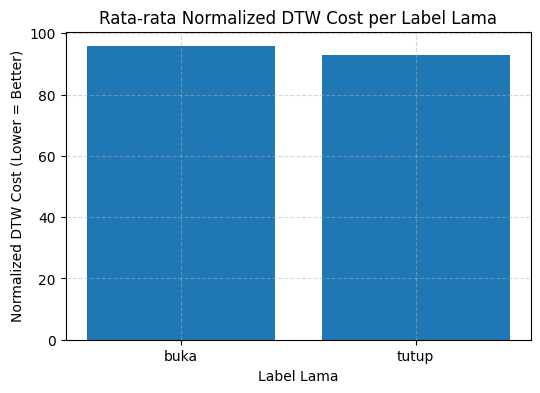

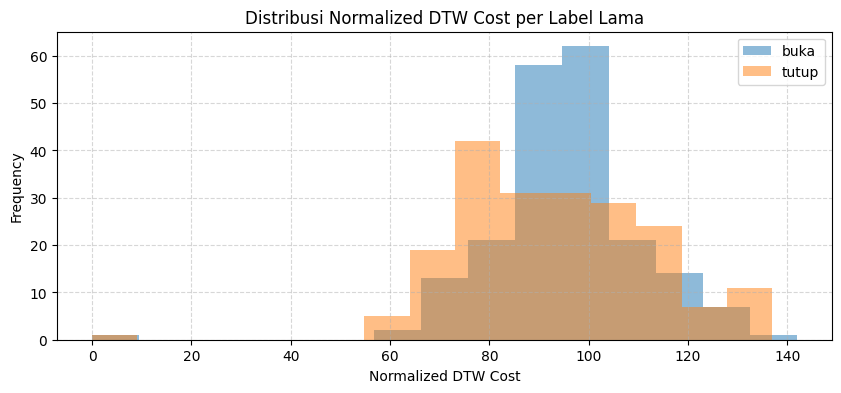

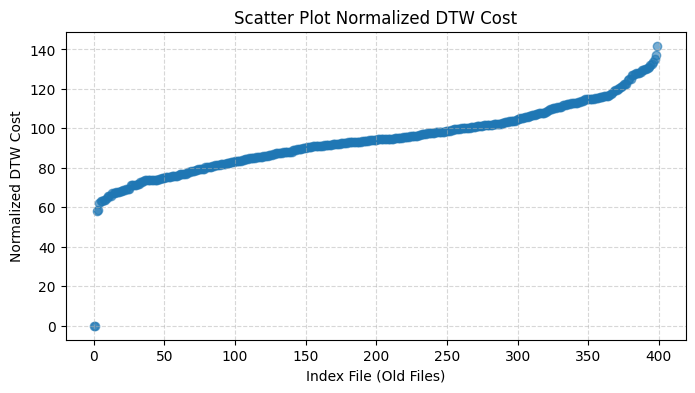


Visualisasi Warp Path (DTW Alignment) untuk file terbaik:
File baru     : tutup_baru
File lama best: rekamsuara/user1/tutup/07-11-2025 12.02(10).wav


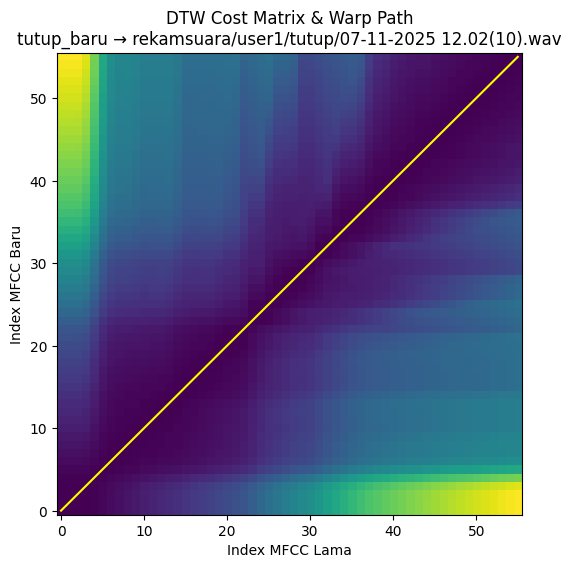

In [29]:
import matplotlib.pyplot as plt

print("\nMenyiapkan visualisasi...")

# Pastikan df punya kolom: old_label, normalized_cost
summary = df.groupby(['old_label'])['normalized_cost'].mean().reset_index()

# =============================
# 1. Barplot rata-rata cost per label lama
# =============================
plt.figure(figsize=(6,4))
plt.bar(summary['old_label'], summary['normalized_cost'])
plt.title("Rata-rata Normalized DTW Cost per Label Lama")
plt.ylabel("Normalized DTW Cost (Lower = Better)")
plt.xlabel("Label Lama")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# =============================
# 2. Histogram distribusi cost per label
# =============================
plt.figure(figsize=(10,4))

for label in df['old_label'].unique():
    subset = df[df['old_label'] == label]['normalized_cost']
    plt.hist(subset, bins=15, alpha=0.5, label=f"{label}")

plt.title("Distribusi Normalized DTW Cost per Label Lama")
plt.xlabel("Normalized DTW Cost")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# =============================
# 3. Scatter Plot cost seluruh file
# =============================
df_sorted = df.sort_values('normalized_cost')

plt.figure(figsize=(8,4))
plt.scatter(range(len(df_sorted)), df_sorted['normalized_cost'], alpha=0.6)
plt.title("Scatter Plot Normalized DTW Cost")
plt.xlabel("Index File (Old Files)")
plt.ylabel("Normalized DTW Cost")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# =============================
# 4. Visualisasi DTW Alignment (File Baru vs File Lama Terbaik)
# =============================
print("\nVisualisasi Warp Path (DTW Alignment) untuk file terbaik:")

# Ambil baris terbaik
best_match = df.sort_values('normalized_cost').iloc[0]
best_old_file = best_match['old_path']
best_old_label = best_match['old_label']
new_name = best_match['new_file']

print(f"File baru     : {new_name}")
print(f"File lama best: {best_old_file}")

# Ambil MFCC lama & baru
m_old = old_mfcc[best_old_label][best_old_file]
m_new = new_mfcc[new_name]

# Hitung DTW
D, wp = librosa.sequence.dtw(X=m_old, Y=m_new, metric='euclidean')

plt.figure(figsize=(6,6))
plt.imshow(D.T, origin='lower', aspect='auto', interpolation='nearest')
plt.plot([p[0] for p in wp], [p[1] for p in wp], color='yellow')
plt.title(f"DTW Cost Matrix & Warp Path\n{new_name} → {best_old_file}")
plt.xlabel("Index MFCC Lama")
plt.ylabel("Index MFCC Baru")
plt.show()
